### **Load libraries**

In [1]:
import sys
sys.path.append('../src')
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import risk_kit as rk
import tensorflow as tf
from tensorflow.keras.layers import Layer, Dense, LayerNormalization, Dropout
import importlib

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.api import VAR
from mgarch import mgarch

import itertools
import random

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

### **Load data**

In [4]:
rets = pd.read_csv('../temp_references/all_rets.csv', index_col=0)
stocks = pd.read_csv('../temp_references/all_stocks.csv', index_col=0)
selected_stocks = pd.read_csv('../temp_references/selected_stocks_rets.csv', index_col=0).columns

rets.index = pd.to_datetime(rets.index).to_period('W')
stocks.index = pd.to_datetime(stocks.index).to_period('W')

In [5]:
# Define the number of periods per year for all calculations
# 252 is an approximation for daily
# 54 for weekly
# 12 for monthly
periods_per_year = 54

In [6]:
rets_backup = rets.copy(); stocks_backup = stocks.copy()

# Determine the dataset size
# Uncomment if a smaller dataset is desired
# rets = rets.loc['2021-01-01':]
# stocks = stocks.loc['2021-01-01':]

# **Estimation of future Moving Average Returns**

## **Analysis of stationarity**

In [7]:
# Analysis of stationarity for the whole series
for stock in rets.columns:
    print(f'Augmented Dickey Fuller Test p-value for non-stationarity of level {stock} series: {round(adfuller(rets[stock])[1], 4)}')

# All return series are stationary, however, differentiating by first order seems to result in better models

Augmented Dickey Fuller Test p-value for non-stationarity of level BOGOTA.CL series: 0.0
Augmented Dickey Fuller Test p-value for non-stationarity of level BVC.CL series: 0.0
Augmented Dickey Fuller Test p-value for non-stationarity of level CELSIA.CL series: 0.0
Augmented Dickey Fuller Test p-value for non-stationarity of level CEMARGOS.CL series: 0.0
Augmented Dickey Fuller Test p-value for non-stationarity of level CIBEST.CL series: 0.0
Augmented Dickey Fuller Test p-value for non-stationarity of level CNEC.CL series: 0.0
Augmented Dickey Fuller Test p-value for non-stationarity of level CONCONCRET.CL series: 0.0
Augmented Dickey Fuller Test p-value for non-stationarity of level CORFICOLCF.CL series: 0.0
Augmented Dickey Fuller Test p-value for non-stationarity of level ECOPETROL.CL series: 0.0
Augmented Dickey Fuller Test p-value for non-stationarity of level ENKA.CL series: 0.0
Augmented Dickey Fuller Test p-value for non-stationarity of level ETB.CL series: 0.0
Augmented Dickey F

## **Model 1: Annualized Yearly Returns from the Last 3 Years**

In [8]:
# Compare with the expected returns calculated from historical returns
historical_annualized_returns = rk.summary_stats(rets.iloc[-162:], periods_per_year=periods_per_year)['Annualized Return']
historical_annualized_returns

BOGOTA.CL        0.179984
BVC.CL           0.331144
CELSIA.CL        0.309715
CEMARGOS.CL      0.633388
CIBEST.CL        0.362080
CNEC.CL         -0.490924
CONCONCRET.CL    0.255567
CORFICOLCF.CL    0.090435
ECOPETROL.CL     0.095054
ENKA.CL         -0.111051
ETB.CL          -0.278098
EXITO.CL         0.105320
GEB.CL           0.362533
GRUBOLIVAR.CL    0.234909
GRUPOARGOS.CL    0.233262
GRUPOAVAL.CL     0.162605
GRUPOSURA.CL     0.145231
HCOLSEL.CL       0.250958
ICOLCAP.CL       0.228967
ISA.CL           0.187420
MINEROS.CL       1.056421
NUTRESA.CL       0.729944
PFAVAL.CL        0.171716
PFCIBEST.CL      0.403820
PFCORFICOL.CL    0.146066
PFDAVVNDA.CL    -0.004489
PFGRUPOARG.CL    0.442243
PFGRUPSURA.CL    0.664066
PROMIGAS.CL      0.223362
TERPEL.CL        0.426219
AAPL             0.244017
AGUAS-A.SN       0.326647
AMZN             0.250309
ANDINA-B.SN      0.462467
BAC              0.184474
BAP              0.279732
BRK-B            0.220646
BSANTANDER.SN    0.343043
BVN         

## **Model 2: VAR bagging**

In [9]:
# Get the 1st order integration for the returns series
rets_integrated = (rets - rets.shift(1)).dropna()

In [10]:
symbols_list = list(rets.columns.values) # List of all available stock symbols
n_iterations = 2000 # The number of iterations of VAR models to perform
set_size = 10 # Number of symbols modeled in each iteration
periods_to_forecast = 4 # Number of periods to forecast

# Initialize an empty list of sets of stock symbols
iterations_symbols = []

for i in range(n_iterations):
    # For each iteration of the model, select a random set of 'set_size' stock symbols
    iterations_symbols.append(random.sample(symbols_list, set_size))

In [11]:
# Initialize a dictionary of dictionaries where the results of each iteration will be stored
prediction_results = {symbol: {} for symbol in symbols_list}

for i, symbols_selection in enumerate(iterations_symbols):
    # In each iteration, generate a dataset with the stocks selected for the iteration only
    subset_df = rets_integrated[symbols_selection]
    
    # Compare the IC (Information Criteria) scores for VAR models of various number of lags to select the ideal number of lags
    varmod = VAR(subset_df)
    lag_sel = varmod.select_order(10)
    
    # Select the best number of lags according to the AIC criterion
    n_lags = lag_sel.aic
    print(f'Iteration {i}, ideal_n_lags: {n_lags}')
    
    # Fit the model for the iteration
    var_model = VAR(subset_df).fit(maxlags=n_lags, trend='c')

    # Predict the following 'periods_to_forecast' periods
    predictions = var_model.forecast(subset_df.iloc[-n_lags:].values, periods_to_forecast)
    predictions = pd.DataFrame(predictions)

    # Append the predicted values to the 'prediction_results' dictionary
    for l in predictions:
        prediction_results[symbols_selection[l]][i] = predictions[l]
    print(f'Iteration {i+1} finished')

Iteration 0, ideal_n_lags: 9
Iteration 1 finished
Iteration 1, ideal_n_lags: 6
Iteration 2 finished
Iteration 2, ideal_n_lags: 7
Iteration 3 finished
Iteration 3, ideal_n_lags: 10
Iteration 4 finished
Iteration 4, ideal_n_lags: 8
Iteration 5 finished
Iteration 5, ideal_n_lags: 8
Iteration 6 finished
Iteration 6, ideal_n_lags: 7
Iteration 7 finished
Iteration 7, ideal_n_lags: 10
Iteration 8 finished
Iteration 8, ideal_n_lags: 7
Iteration 9 finished
Iteration 9, ideal_n_lags: 10
Iteration 10 finished
Iteration 10, ideal_n_lags: 8
Iteration 11 finished
Iteration 11, ideal_n_lags: 7
Iteration 12 finished
Iteration 12, ideal_n_lags: 10
Iteration 13 finished
Iteration 13, ideal_n_lags: 8
Iteration 14 finished
Iteration 14, ideal_n_lags: 8
Iteration 15 finished
Iteration 15, ideal_n_lags: 7
Iteration 16 finished
Iteration 16, ideal_n_lags: 8
Iteration 17 finished
Iteration 17, ideal_n_lags: 9
Iteration 18 finished
Iteration 18, ideal_n_lags: 8
Iteration 19 finished
Iteration 19, ideal_n_lags:

KeyboardInterrupt: 

In [ ]:
import warnings
warnings.filterwarnings('ignore')

# Copy the 'prediction_results' dictionary to invert the integration of the copy and set the index for predicted dates
prediction_results_processed = prediction_results.copy()
for symbol in prediction_results:
    # For each stock in 'prediction_results', convert the predictions into a dataframe
    pred_df = pd.DataFrame(prediction_results[symbol])

    # Get the average predictions for each day
    pred_series = pred_df.mean(axis=1)

    # Invert the integration by taking the last actual returns and add it to the predictions, then do a cumulative sum
    pred_series = rets[symbol][-1] + pred_series.cumsum()
    
    # Generate an index for the future dates
    #future_dates = pd.date_range(start=rets.index.max().to_timestamp() + pd.Timedelta(value=1, unit='d'), periods=periods_to_forecast)
    future_dates = pd.date_range(start=rets.index.max().to_timestamp() + pd.Timedelta(value=7, unit='d'), periods=periods_to_forecast, freq='W-SUN').to_period('W') # Weekly
    pred_series.index = future_dates
    
    # Add the series of average predicted returns for the stock to the 'prediction_results_processed' dictionary
    prediction_results_processed[symbol] = pred_series

In [ ]:
# Visualize the predictions of any stock
symbol = 'PFGRUPSURA.CL'
concat_df = pd.concat([rets[symbol][-50:], pd.DataFrame(prediction_results_processed[symbol], columns=[symbol])], axis=1)

concat_df.plot()
#prediction_results_processed[symbol].plot()
plt.grid(alpha=.4)
plt.title(symbol)
plt.show()

In [ ]:
# Calculate the exptected annual returns for each stock
# Initialize an empty dictionary where the returns will be stored
expected_annualized_rets = {}

for symbol in prediction_results_processed:
    # Calculate the weighted average returns from the predictions and then annualize them
    # Uncomment the method of weighting for the averaging and annualization of the returns
    
    ### Raw predicted returns annualized
    # expected_annualized_returns = ((prediction_results_processed[symbol] + 1).prod()**(1/len(prediction_results_processed[symbol])))**(periods_per_year) - 1
    
    ### Linearly decaying weighted returns annualized
    # weight_indexes = np.array([i+1 for i in range(periods_to_forecast)])
    # linear_decay_w = (periods_to_forecast - weight_indexes + 1)/weight_indexes.sum()
    # expected_annualized_returns = (1 + np.sum(prediction_results_processed[symbol]*linear_decay_w))**periods_per_year - 1

    ### Exponentially decaying weighted returns annualized
    weight_indexes = np.array([i+1 for i in range(periods_to_forecast)])
    lambda_ = 0.2
    exponential_decay_w = np.exp(-lambda_*weight_indexes)/np.exp(-lambda_*weight_indexes).sum()
    expected_annualized_returns = (1 + np.sum(prediction_results_processed[symbol]*exponential_decay_w))**periods_per_year - 1

    expected_annualized_rets[symbol] = expected_annualized_returns

In [ ]:
# Predictions of annualized returns for the VAR Bagging model
var_bagging_expected_annualized_rets = expected_annualized_rets
pd.Series(var_bagging_expected_annualized_rets)

## **Model 3: Transformer Neural Network**

### **Generate the data**

In [8]:
data = rets.values

# Prepare the data for training
def create_dataset(data, time_window=1):
    X, Y = [], []

    for i in range(len(data)-time_window):
        X.append(data[i:(i+time_window)])
        Y.append(data[i + time_window])
    return np.array(X), np.array(Y)

# Generate the sequences of data
time_window = 54
X, Y = create_dataset(data, time_window)

print("Shape of X:", X.shape)
print("Shape of Y:", Y.shape)

Shape of X: (468, 54, 79)
Shape of Y: (468, 79)


### **Implement Positional Encoding**

In [9]:
# Positional encoding represents the data in time steps
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, sequence_length, d_model):
        super().__init__()
        self.sequence_length = sequence_length
        self.d_model = d_model

    def call(self, inputs):
        positions = np.arange(self.sequence_length)[:, np.newaxis]
        # Calculate div_term for even indices only (half of d_model, rounded up)
        num_encoding_dims = (self.d_model + 1) // 2
        div_term = np.exp(np.arange(0, num_encoding_dims) * (-np.log(10000.0) / self.d_model))
        pos_encoding = np.zeros((self.sequence_length, self.d_model))
        # Assign sin to even indices
        pos_encoding[:, 0::2] = np.sin(positions * div_term)
        # Assign cos to odd indices (only up to the number of odd indices available)
        pos_encoding[:, 1::2] = np.cos(positions * div_term[:self.d_model//2])
        return inputs + tf.convert_to_tensor(pos_encoding, dtype=tf.float32)

### **Implement the Transformer Encoder block**

In [10]:
# Implement Multi-Head Self-Attention, Layer Normalization, and Feed-Forward Networks
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0.1):
    # Multi-Head Self-Attention
    x = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=head_size, dropout=dropout)(inputs, inputs)
    x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x + inputs)

    # Feed-Forward Network
    ff_output = tf.keras.layers.Dense(ff_dim, activation="relu")(x)
    ff_output = tf.keras.layers.Dense(inputs.shape[-1])(ff_output)
    x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x + ff_output)

    return x

### **Build the Transformer Model**

In [11]:
# Function that builds the model that will take inputs, encode them, and then make a prediction for the input_shape[1] items
def build_transformer_model(input_shape, head_size=64, num_heads=4, ff_dim=128, num_transformer_blocks=2, dropout=0.1):
    inputs = tf.keras.layers.Input(shape=input_shape)
    
    # Positional Encoding
    x = PositionalEncoding(sequence_length=input_shape[0], d_model=input_shape[1])(inputs)
    
    # Transformer Encoder Blocks
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)
    
    # Global Average Pooling over time dimension
    x = tf.keras.layers.GlobalAveragePooling1D()(x)

    # Output Layer (input_shape[1]-dimensional vector)
    outputs = tf.keras.layers.Dense(input_shape[1])(x)

    # Build Model
    model = tf.keras.Model(inputs, outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss="mse",
        metrics=["mae", tf.keras.metrics.RootMeanSquaredError]
    )
    
    return model

### **Train the Model**

In [12]:
input_shape = (time_window, X.shape[2]) # Shape of each input
head_size = 128
num_heads = 8
ff_dim = 512
num_transformer_blocks = 6
dropout = 0.1

model = build_transformer_model(input_shape)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 54, 79)            │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ positional_encoding           │ (None, 54, 79)            │               0 │ input_layer[0][0]          │
│ (PositionalEncoding)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ multi_head_attention          │ (None, 54, 79)            │          81,743 │ positional_encoding[0][0], │
│ (MultiHeadAttention)          │                           │                 │ positional_encoding[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add (Add)                     │ (None, 54, 79)            │               0 │ multi_head_attention[0][0… │
│                               │                           │                 │ positional_encoding[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ layer_normalization           │ (None, 54, 79)            │             158 │ add[0][0]                  │
│ (LayerNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense (Dense)                 │ (None, 54, 128)           │          10,240 │ layer_normalization[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_1 (Dense)               │ (None, 54, 79)            │          10,191 │ dense[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add_1 (Add)                   │ (None, 54, 79)            │               0 │ layer_normalization[0][0], │
│                               │                           │                 │ dense_1[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ layer_normalization_1         │ (None, 54, 79)            │             158 │ add_1[0][0]                │
│ (LayerNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ multi_head_attention_1        │ (None, 54, 79)            │          81,743 │ layer_normalization_1[0][… │
│ (MultiHeadAttention)          │                           │                 │ layer_normalization_1[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add_2 (Add)                   │ (None, 54, 79)            │               0 │ multi_head_attention_1[0]… │
│                               │                           │                 │ layer_normalization_1[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ layer_normalization_2         │ (None, 54, 79)            │             158 │ add_2[0][0]                │
│ (LayerNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_2 (Dense)               │ (None, 54, 128)           │          10,24

 Total params: 211,300 (825.39 KB)

 Trainable params: 211,300 (825.39 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# Train the model
history = model.fit(
    X, Y,
    epochs=50,
    batch_size=32
)

Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - loss: 0.2560 - mae: 0.3928 - root_mean_squared_error: 0.5035
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0488 - mae: 0.1787 - root_mean_squared_error: 0.2197
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0140 - mae: 0.0929 - root_mean_squared_error: 0.1179
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0065 - mae: 0.0594 - root_mean_squared_error: 0.0807
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0038 - mae: 0.0449 - root_mean_squared_error: 0.0613
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0029 - mae: 0.0380 - root_mean_squared_error: 0.0540
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - loss: 0.0027 - mae: 0.0346 - root_mean_squared_error: 0.0520
Epoch 8/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0027 - mae: 0.0335 - root_mean_squared_error: 0.0522
Epoch 9/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0030 - mae: 0.0322 - root_m

### **Perform predictions**

In [14]:
# Generate the input for the prediction of future period

# Add a dummy array for the future period,
# so that the generate_dataset function will capture the latest observation in the last sequence
data_preds = data.copy()
data_preds = np.concatenate((data_preds, np.expand_dims(np.zeros_like(data_preds[-1]), axis=0)))

X_, Y_ = create_dataset(data_preds, time_window)

In [15]:
periods_to_forecast = 4
preds = []
pred_inputs = np.expand_dims(X_[-1], axis=0)

for i in range(periods_to_forecast):
    prediction = model.predict(pred_inputs)
    preds.append(prediction[0])
    pred_inputs = np.concatenate((pred_inputs[0][1:], np.expand_dims(prediction[0], axis=0)))
    pred_inputs = np.expand_dims(pred_inputs, axis=0)

preds = np.array(preds)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


In [16]:
preds_df = pd.DataFrame(preds, columns=rets.columns)

future_dates = pd.date_range(start=rets.index.max().to_timestamp() + pd.Timedelta(value=7, unit='d'), periods=periods_to_forecast, freq='W-SUN').to_period('W') # Weekly
preds_df = pd.DataFrame(preds, columns=rets.columns, index=future_dates)

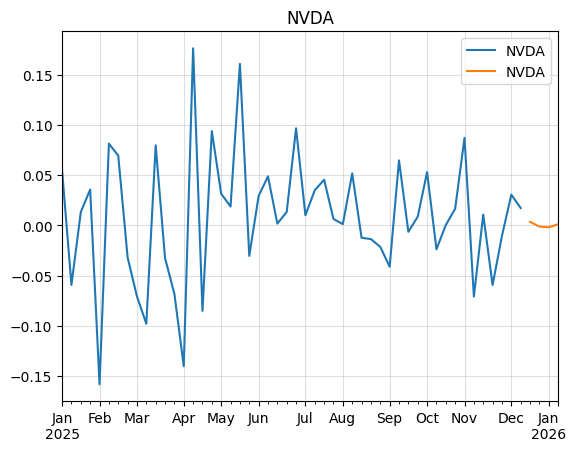

In [17]:
# Visualize the predictions of any stock
symbol = 'NVDA'#'PFGRUPSURA.CL'
concat_df = pd.concat([rets[symbol][-50:], preds_df[symbol]], axis=1)

concat_df.plot()
#prediction_results_processed[symbol].plot()
plt.grid(alpha=.4)
plt.title(symbol)
plt.show()

In [18]:
# Calculate the exptected annual returns for each stock
# Initialize an empty dictionary where the returns will be stored
expected_annualized_rets = {}

for symbol in preds_df.columns:
    # Calculate the weighted average returns from the predictions and then annualize them
    # Uncomment the method of weighting for the averaging and annualization of the returns
    
    ### Raw predicted returns annualized
    # expected_annualized_returns = ((prediction_results_processed[symbol] + 1).prod()**(1/len(prediction_results_processed[symbol])))**(periods_per_year) - 1
    
    ### Linearly decaying weighted returns annualized
    # weight_indexes = np.array([i+1 for i in range(periods_to_forecast)])
    # linear_decay_w = (periods_to_forecast - weight_indexes + 1)/weight_indexes.sum()
    # expected_annualized_returns = (1 + np.sum(prediction_results_processed[symbol]*linear_decay_w))**periods_per_year - 1

    ### Exponentially decaying weighted returns annualized
    weight_indexes = np.array([i+1 for i in range(periods_to_forecast)])
    lambda_ = 0.2
    exponential_decay_w = np.exp(-lambda_*weight_indexes)/np.exp(-lambda_*weight_indexes).sum()
    expected_annualized_returns = (1 + np.sum(preds_df[symbol]*exponential_decay_w))**periods_per_year - 1

    expected_annualized_rets[symbol] = expected_annualized_returns

In [19]:
# Predictions of annualized returns for the Transformer model
transformer_expected_annualized_rets = expected_annualized_rets
pd.Series(transformer_expected_annualized_rets).sort_values(ascending=False)

CHILE.SN         3.035999
ITAUCL.SN        2.842808
NUTRESA.CL       2.445557
MINEROS.CL       1.986490
COLBUN.SN        1.780883
PFGRUPOARG.CL    1.652856
ENKA.CL          1.593050
GRUPOSURA.CL     1.532888
CBU7.L           1.352775
ENTEL.SN         1.128650
PBR              1.105071
F                0.854451
GRUBOLIVAR.CL    0.671314
C                0.648365
PFE              0.637480
ICOLCAP.CL       0.632624
BVN              0.629293
CELSIA.CL        0.612209
VOLCABC1.LM      0.608431
CONCONCRET.CL    0.562241
SCCO             0.560310
COPEC.SN         0.548688
ECOPETROL.CL     0.520329
SUAS.L           0.488221
PARAUCO.SN       0.421962
BAP              0.410573
GRUPOAVAL.CL     0.390730
BAC              0.332531
CPAC             0.258046
GE               0.252642
AMZN             0.250563
PROMIGAS.CL      0.243969
JPM              0.221306
BOGOTA.CL        0.195677
PFAVAL.CL        0.190657
TERPEL.CL        0.131225
SGLD.L           0.130562
EIMI.L           0.085488
CNEC.CL     

In [21]:
# Compare returns of different models:
"""
pd.Series(historical_annualized_returns)
pd.Series(var_bagging_expected_annualized_rets)
pd.Series(transformer_expected_annualized_rets)
"""

'\npd.Series(historical_annualized_returns)\npd.Series(var_bagging_expected_annualized_rets)\npd.Series(transformer_expected_annualized_rets)\n'

In [20]:
# Uncomment the predictions of the model that was preferred
# expected_returns = historical_annualized_returns
# expected_returns = var_bagging_expected_annualized_rets
expected_returns = transformer_expected_annualized_rets

# **Covariance matrix estimation**

## **Model 1: Historical Covariance Matrix from the last 3 years**

In [21]:
# Simple long-term covariance
covmat = rets[selected_stocks].iloc[-periods_per_year * 3:].cov()
covmat

,CNEC.CL,AAPL,AMZN,BAC,BAP,BRK-B,BVN,C,CBU7.L,CFMITNIPSA.SN,CSPX.L,EIMI.L,F,GOOGL,IJPA.L,JETS,JNJ,JPM,META,NKE,NVDA,PBR,PFE,SCCO,SGLD.L,SPXS.L,SUAS.L,URA,VOLCABC1.LM,VOO
CNEC.CL,0.005918,0.000343,0.000200,0.000429,0.000364,0.000166,0.000405,0.000486,-0.000003,0.000169,0.000176,0.000204,0.000367,0.000460,0.000127,0.000228,-0.000092,0.000367,0.000162,0.000119,0.000230,0.000224,0.000042,0.000622,0.000077,0.000178,0.000198,0.000852,0.000930,0.000195
AAPL,0.000343,0.001310,0.000651,0.000406,0.000206,0.000166,0.000272,0.000486,0.000012,0.000165,0.000401,0.000319,0.000571,0.000787,0.000347,0.000471,0.000109,0.000346,0.000732,0.000586,0.000907,-0.000061,0.000266,0.000592,0.000011,0.000405,0.000359,0.000330,0.000106,0.000471
AMZN,0.000200,0.000651,0.001573,0.000598,0.000300,0.000216,0.000455,0.000809,0.000013,0.000108,0.000513,0.000369,0.000479,0.000907,0.000466,0.000700,-0.000125,0.000572,0.001135,0.000457,0.001470,-0.000063,0.000054,0.000792,0.000009,0.000511,0.000473,0.000851,0.000044,0.000578
BAC,0.000429,0.000406,0.000598,0.001537,0.000639,0.000502,0.000454,0.001337,-0.000031,0.000294,0.000481,0.000342,0.000877,0.000280,0.000456,0.000968,0.000160,0.001045,0.000468,0.000544,0.000637,0.000370,0.000172,0.000871,-0.000022,0.000483,0.000526,0.000806,0.000373,0.000526
BAP,0.000364,0.000206,0.000300,0.000639,0.001216,0.000233,0.000833,0.000552,0.000007,0.000220,0.000276,0.000290,0.000642,-0.000008,0.000314,0.000553,0.000057,0.000471,0.000258,0.000300,0.000400,0.000248,0.000020,0.000776,0.000039,0.000281,0.000321,0.000551,0.000410,0.000272
BRK-B,0.000166,0.000166,0.000216,0.000502,0.000233,0.000502,0.000167,0.000513,-0.000002,0.000089,0.000176,0.000139,0.000384,0.000100,0.000217,0.000357,0.000158,0.000448,0.000254,0.000269,0.000116,0.000179,0.000142,0.000344,0.000021,0.000179,0.000186,0.000199,0.000201,0.000223
BVN,0.000405,0.000272,0.000455,0.000454,0.000833,0.000167,0.002960,0.000482,-0.000004,0.000214,0.000283,0.000383,0.000552,0.000538,0.000294,0.000400,0.000082,0.000350,0.000346,0.000224,0.000629,0.000218,0.000058,0.001530,0.000383,0.000280,0.000268,0.000791,0.000951,0.000328
C,0.000486,0.000486,0.000809,0.001337,0.000552,0.000513,0.000482,0.001762,-0.000034,0.000280,0.000533,0.000446,0.000872,0.000492,0.000564,0.001006,0.000127,0.001125,0.000697,0.000609,0.000871,0.000417,0.000146,0.001040,-0.000009,0.000532,0.000562,0.000926,0.000304,0.000585
CBU7.L,-0.000003,0.000012,0.000013,-0.000031,0.000007,-0.000002,-0.000004,-0.000034,0.000044,0.000002,0.000012,0.000020,0.000012,0.000016,0.000018,-0.000024,0.000036,-0.000050,0.000048,0.000059,-0.000032,-0.000059,0.000016,-0.000006,0.000027,0.000012,0.000017,-0.000015,0.000037,0.000005
CFMITNIPSA.SN,0.000169,0.000165,0.000108,0.000294,0.000220,0.000089,0.000214,0.000280,0.000002,0.000358,0.000131,0.000174,0.000291,0.000117,0.000194,0.000223,0.000049,0.000169,0.000069,0.000183,0.000074,0.000224,0.000049,0.000395,0.000044,0.000131,0.000145,0.000215,0.000126,0.000120


## **Model 2: Multivariate GARCH**

In [25]:
"""
# This section is likely to get deprecated as it's extremely slow to run.

summary_stats = rk.summary_stats(rets[selected_stocks], periods_per_year=periods_per_year, riskfree_rate=0)
returns = summary_stats['Annualized Return']

# Recent covariance prediction based on recent days with GARCH model
vol = mgarch('t')
vol.fit(rets[selected_stocks])
nperiods = 4
covmat = vol.predict(nperiods)
covmat = pd.DataFrame(data=covmat['cov'], index=returns.index, columns=returns.index)
"""

"\n# This section is likely to get deprecated as it's extremely slow to run.\n\nsummary_stats = rk.summary_stats(rets[selected_stocks], periods_per_year=periods_per_year, riskfree_rate=0)\nreturns = summary_stats['Annualized Return']\n\n# Recent covariance prediction based on recent days with GARCH model\nvol = mgarch('t')\nvol.fit(rets[selected_stocks])\nnperiods = 4\ncovmat = vol.predict(nperiods)\ncovmat = pd.DataFrame(data=covmat['cov'], index=returns.index, columns=returns.index)\n"

# **Export predicted returns and covariance matrix**

In [22]:
pd.Series(expected_annualized_rets)[selected_stocks].to_csv('../temp_references/expected_returns.csv', header=None)

In [23]:
covmat.to_csv('../temp_references/expected_covmat.csv')